Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


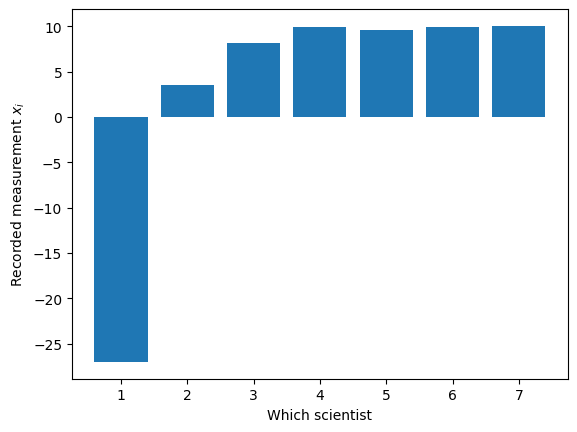

In [2]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


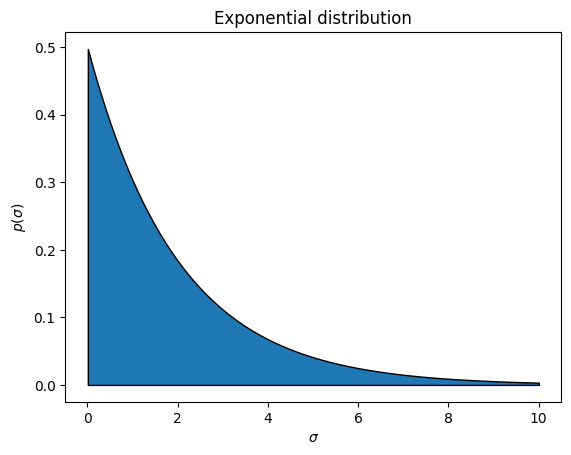

In [3]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\\sigma$")
plt.ylabel("$p(\\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [4]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)
    
    # YOUR CODE HERE
    if (sigma <= 0).any():
        return float('-inf')
    log_prior_mu = dist.Normal(0.0, alpha).log_prob(mu)
    log_prior_sigma = dist.Exponential(rate=beta).log_prob(sigma).sum(0)
    log_likelihood = dist.Normal(mu, sigma).log_prob(measurements).sum(0)

    log_joint = log_prior_mu + log_prior_sigma + log_likelihood 
    return log_joint

#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [5]:
# (GRADING)

In [6]:
# (GRADING)

In [7]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [8]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """
    
    # YOUR CODE HERE
    q_mu = dist.Normal(mu, 0.5)
    q_sigma = dist.Normal(sigma, torch.ones(7) * 0.2)
    return q_mu, q_sigma


### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [9]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [10]:
def mh_ratio(mu, sigma, alpha, beta):
    """
    Compute the Metropolis-Hastings acceptance ratio, given your proposal distribution and the target.

    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    accept_prob : scalar, number between 0 and 1
    new_mu      : proposed value for mu
    new_sigma   : proposed value for sigma
    """

    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)
    
    # YOUR CODE HERE
    new_mu = q_mu.sample()
    new_sigma = q_sigma.sample()
    log_joint_old = log_joint(mu, sigma, alpha, beta)
    log_joint_new = log_joint(new_mu, new_sigma, alpha, beta)

    accept_prob = min(1, torch.exp(log_joint_new - log_joint_old))
    return accept_prob, new_mu, new_sigma


## Running MCMC

We've supplied the outer loop for you, and an `mcmc_step` function -- it will call and execute your `mh_ratio` function. You should *not* need to edit these functions below!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [11]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    Run a sigle MCMC step. Calls your `mh_ratio` function.
    
    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """
    
    accepted = False
    accept_prob, new_mu, new_sigma = mh_ratio(mu, sigma, alpha, beta)
    
    if dist.Bernoulli(accept_prob).sample():
        mu = new_mu
        sigma = new_sigma
        accepted = True
    return mu, sigma, accepted

def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [12]:
def algo_parameters():
    """ TODO: set these to appropriate values:
    
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """
    
    # YOUR CODE HERE    
    N_samples = 5000
    N_burnin = 1000
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [13]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.2608


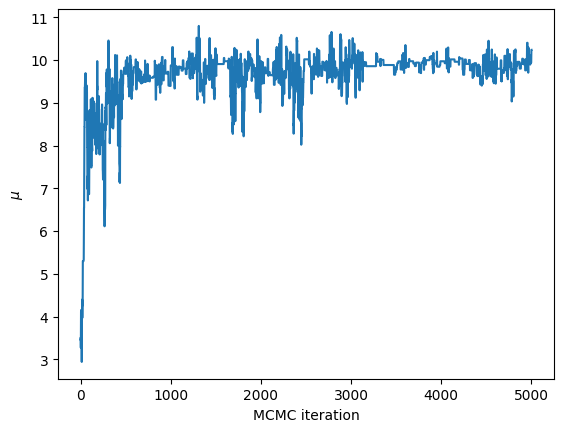

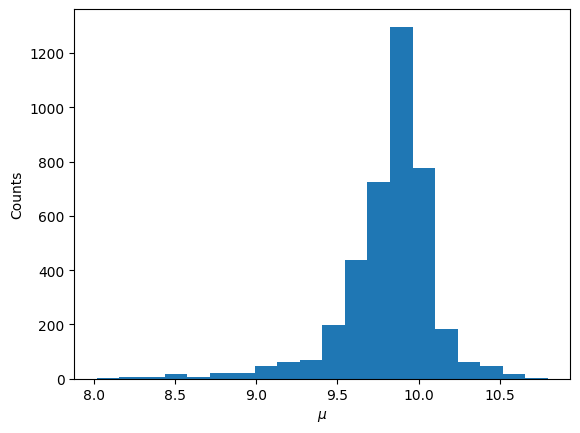

In [14]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\\mu$")
plt.ylabel("Counts");

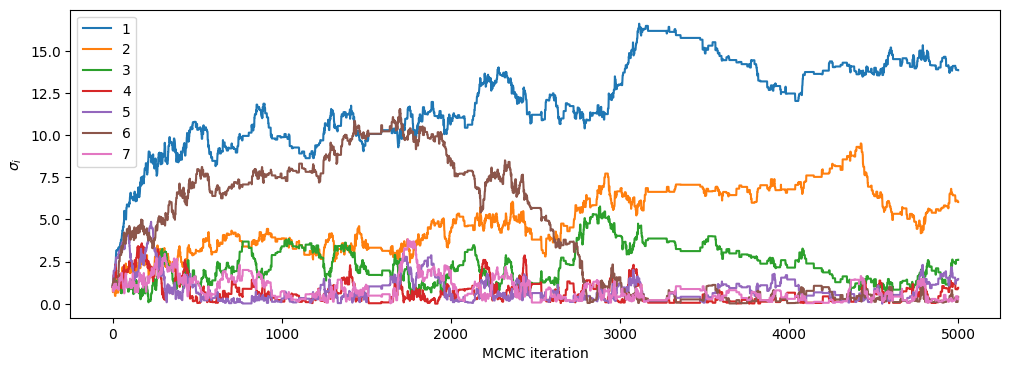

In [15]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\\sigma_i$");

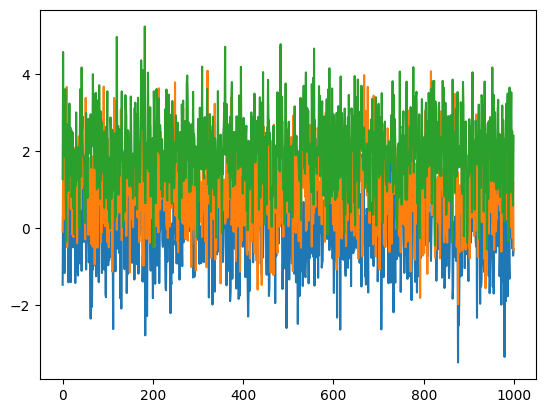

In [16]:
plt.plot(np.random.randn(1000,3) +np.arange(3))

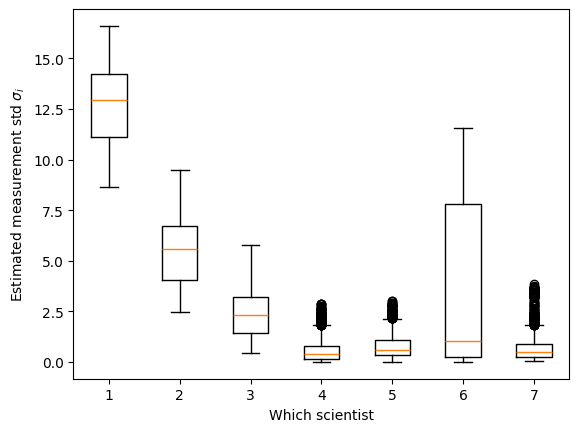

In [17]:
plt.boxplot(sigma_chain[N_burnin:].numpy(), positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [18]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    # YOUR CODE HERE
    return torch.mean(mu_chain[N_burnin:])
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """
    
    # YOUR CODE HERE
    post_mu = mu_chain[N_burnin:]
    return torch.mean((post_mu < 9.0).float())

In [19]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.8155
Pr(mu < 9) = 0.0205


#### Ignore the following cells. They are used by the grading system.

In [20]:
# (GRADING)

In [21]:
# (GRADING)

In [22]:
# (GRADING)

In [23]:
# (GRADING)

In [24]:
# (GRADING)

# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, **in MAX 150 WORDS EACH**, for up to two points each.

1. Describe your choices of MCMC proposal distributions. Why did you choose them? How do you evaluate whether they are "good"?
2. Here, the parameters $\alpha$ and $\beta$ were left fixed. Suppose instead we would like to do MCMC inference over them as well. Outline everything that would be necessary to implement this — what new functions would you have to define, and what would need to change relative to your existing code? How do you think this might change your results, if at all?


Question 1:

For $\mu$, $q(\mu'|\mu)$ ~ $Normal(\mu, 0.5^2)$

For $\sigma_i$, $q(\sigma_i'|\sigma_i)$ ~ $Normal(\sigma_i, 0.2^2)$

Both proposals are Gaussians which depend on the current state, with some step size, so the chain explores locally. The step size for $\mu$ is larger because $\mu$, the underlying physical value, is more uncertain, while $\sigma_i$'s, the scientist-specific measurement error are likely more constrained.

To evaluate "goodness", I looked at the acceptance rate, which came out to be around $0.29$: not too low (steps not excessively large) and not too high (steps not excessively small). I also inspected the trace plots: for $\mu$, after burn-in it fluctuates around a stable level (~9–10) which implies good mixing. For some $\sigma_i$'s, the variance is high, but there are no upward trends in the plots, suggesting reasonable mixing.

Question 2:

To infer over $\alpha$, $\beta$ alongside $\mu$, $\sigma$:

Modified functions:

` log_joint(mu, sigma, alpha, beta) `: Add priors for $\alpha$, $\beta$

`mh_ratio(mu, sigma, alpha, beta)`: Use new $\alpha$ and $\beta$ too for acceptance ratio

`run_mcmc()`: Expand samples tensor to store $\alpha$, $\beta$ chains; initialize alpha_init=50, beta_init=0.5


New functions:

`getmcmcproposal(mu, sigma, alpha, beta)`: Returns 4 Normal proposals (std devs: 0.5, 0.1×7, 5.0, 0.1)

`mcmc_step(mu, sigma, alpha, beta)`: Joint MH step proposing all 4 params

In the final results, alpha shrinks (tighter $\mu$ prior needed) and beta rises (as first scientist is an outlier) and since there is extra uncertainty over alpha and beta, the posterior variances will be higher



